In [1]:
import pdb;
import os
import re
import time
import torch
import PIL.Image as Image

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [2]:
from qwen_vl_utils import process_vision_info
from model.showui.processing_showui import ShowUIProcessor
from model.showui.modeling_showui import ShowUIForConditionalGeneration

num_forward = 1

min_pixels = 256*28*28
max_pixels = 1344*28*28

# skip_ratio indicates how much ratio of visual markers you want to skip
# [1,28,1] means we apply UI guide token selection from 1-th to 28-th layer (28 is the last layer of Qwen2-VL)
skip_rand = False
lm_skip_ratio = 0.5
lm_skip_layer = "[1,28,1]"

# ShowUI preprocessor options
# ui_mask_pre - Prebuild patch selection indices in the preprocessor (this is more efficient, not in model layers)
# ui_mask_ratio - Specify the percentage of patch tokens to select
# ui_mask_rand - Enable random selection instead of uniform selection patches
processor = ShowUIProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", 
    min_pixels=min_pixels, max_pixels=max_pixels,
    ui_mask_pre=True, ui_mask_rand=False, ui_mask_ratio=lm_skip_ratio,
)

/home/zsd/miniconda3/envs/showui/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
qwen_layer_num = 28

def parse_layer_type(str_ranges, L=qwen_layer_num, default=0):
    # 0 is without layer token selection, 1 is with layer token selection
    result = [default] * L
    matches = re.findall(r'\[\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\]', str_ranges)
    for start, end, value in matches:
        start, end, value = int(start) - 1, int(end) - 1, int(value)
        if end >= L:
            end = L - 1
        result[start:end + 1] = [value] * (end - start + 1)
    return result

lm_skip_layer = parse_layer_type(lm_skip_layer, 28)
# print(lm_skip_layer)

model = ShowUIForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
    lm_skip_ratio=lm_skip_ratio, lm_skip_layer=lm_skip_layer,
)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 2/2 [03:11<00:00, 95.52s/it] 


(a) Screenshot patch number: 1296


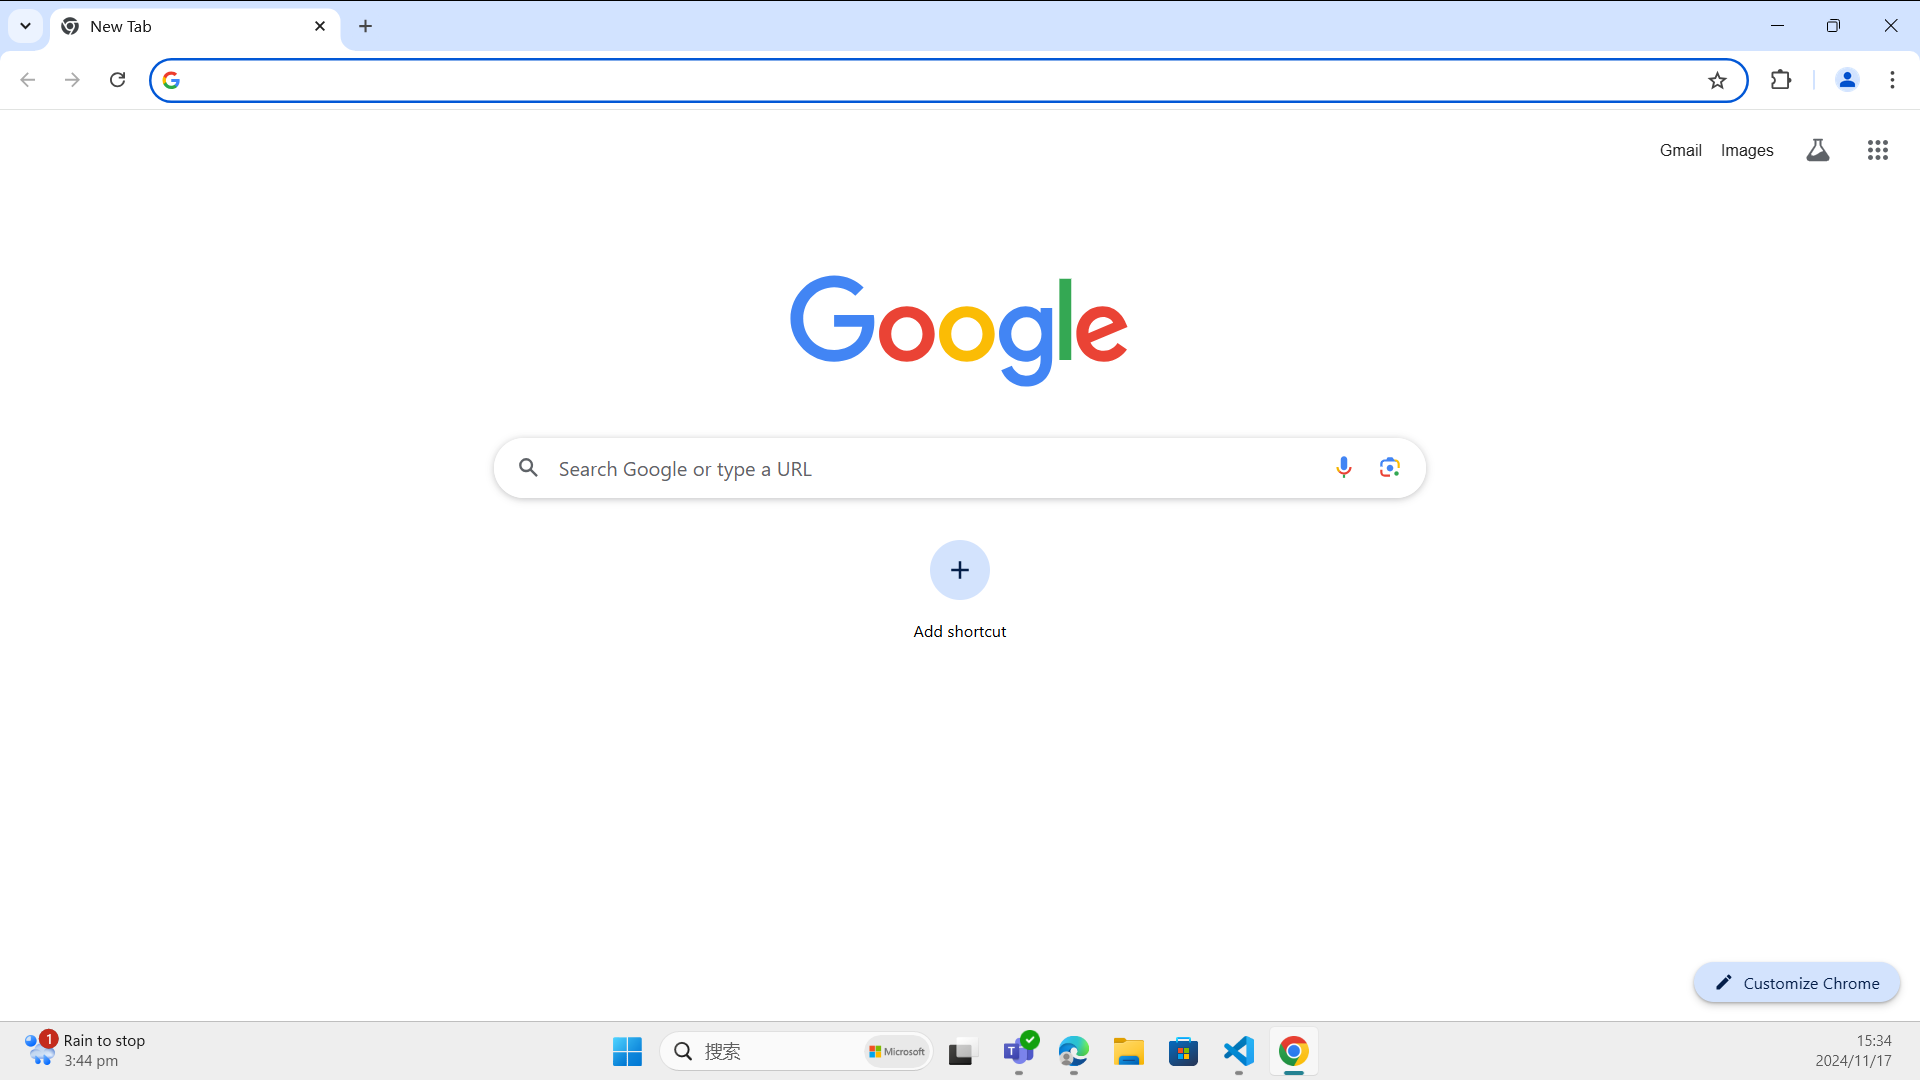

(b) By applying UI-graph, UI Component number: 167


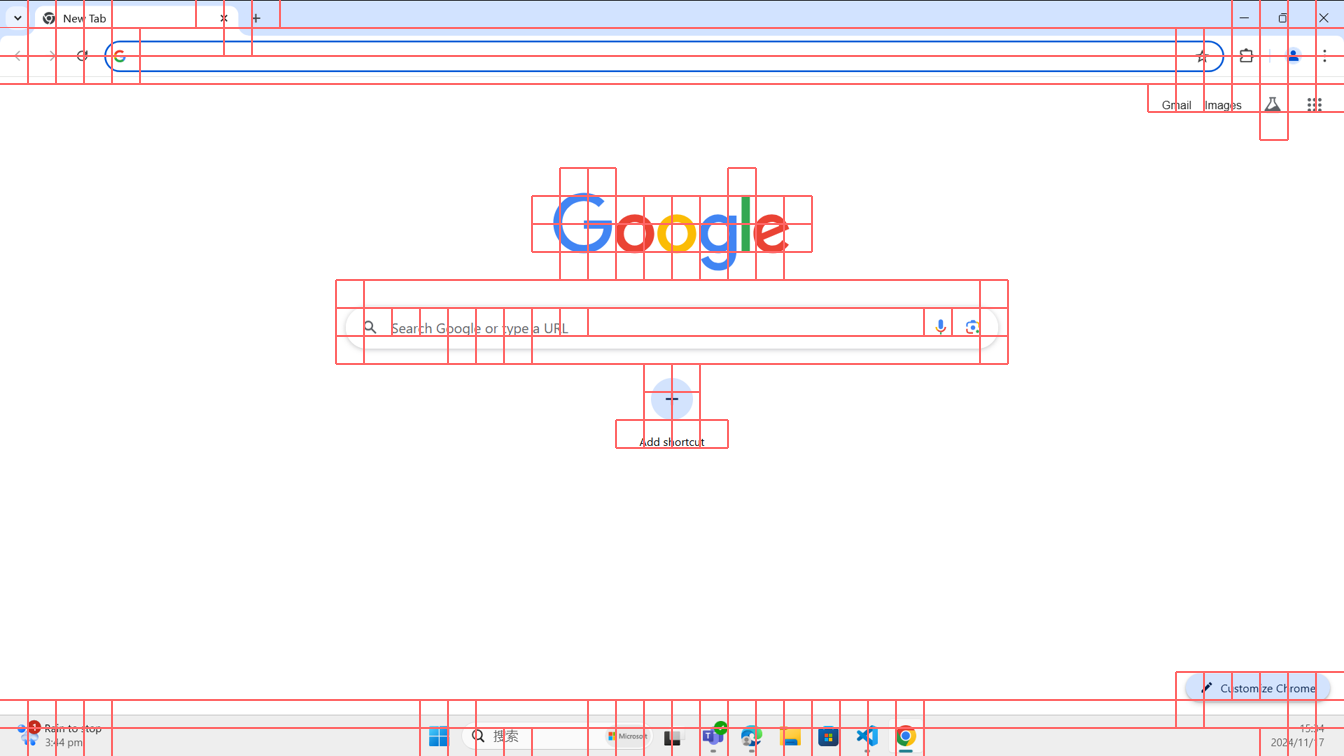

(c) Model output with skip ratio: 0.5
The image shows a screenshot of a web browser, specifically Google Chrome, with the Google logo prominently displayed at the top. The search bar at the top of the screen is active, with the text "Search Google or type a URL" visible. Below the search bar, there is a button labeled "Add shortcut" and a plus sign icon, which likely allows users to add a new shortcut to the browser's menu bar.

On the right side of the screen, there are several icons representing different browser extensions and tools. These include:

1. A Google Chrome logo icon.
2. A Google Chrome logo icon.
3. A Google Chrome logo icon.
4. A Google Chrome logo icon.
5. A Google Chrome logo icon.
6. A Google Chrome logo icon.
7. A Google Chrome logo icon.
8. A Google Chrome logo icon.
9. A Google Chrome logo icon.
10. A Google Chrome logo icon.

At the bottom of the screen, there is a notification bar with the time "3:44 pm" and a message "Rain to stop." Additionally, there is a not

In [4]:
img_url = 'examples/chrome.png'
vis_dir = 'examples'

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Please describe this image."},
            {
                "type": "image",
                "image": img_url,
                "min_pixels": min_pixels,
                "max_pixels": max_pixels,
            },
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True,
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
    ui_graph=True,
    ui_graph_threshold=1,
    ui_graph_vis_dir=vis_dir, # if provided, will be used to save the visualized img
)

inputs = inputs.to("cuda:0")

generated_ids = model.generate(**inputs, max_new_tokens=4096, do_sample=True)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, 
)[0]

print(f"(a) Screenshot patch number: {inputs['patch_assign'].shape[0]}")
display(Image.open(img_url))

print(f"(b) By applying UI-graph, UI Component number: {inputs['patch_assign_len'][0]}")
display(Image.open(f'{vis_dir}/demo.png'))

print(f"(c) Model output with skip ratio: {lm_skip_ratio}")
print(output_text)